# Ensemble Kalman filtering with the Lorenz 63 system
## Illustration of the benefit of advanced data assimilation methods

* Emmanuel Cosme, 2017
* Illustrate Ensemble Kalman filter with Lorenz 63 model

This notebook illustrates in a simple way that for a dynamical system very sparsely observed, using an advanced data assimilation method (here, an Ensemble Kalman filter, EnKF) rather than a crude one (here, direct substitution of the observed variable with the observation) is essential to estimate the system.

The illustration uses the 3-variable, chaotic Lorenz 63 system (https://en.wikipedia.org/wiki/Lorenz_system). This dynamical model is often used to test data assimilation methods, because it displays a chaotic behavior, as the atmosphere and the ocean do, with very low dimensionality.

It is not necessary to know the Ensemble Kalman filter nor to understand the code below to follow the notebook. The code is not optimized and not general to keep it short. In particular, the EnKF implementation misses basic characteristics that are realistic (errors in the observations) or essential with systems of higher dimensions (localisation, inflation, computations in subspaces, etc).

The main steps covered below are:
- Definition of the Lorenz model
- Test the Lorenz model and define a "reference" trajectory
- Test model's sensitivity to changes in initial condition and a model parameter
- Experiment assimilation of observation drawn from the reference trajectory into the model with changed initial condition and parameter: direct substitution, and Ensemble Kalman filtering

## Definition of Lorenz model
The Lorenz system is:
$$ \dot{x} = \sigma (y-x) $$
$$ \dot{y} = x (\rho -z ) -y $$
$$ \dot{z} = xy -\beta z $$
In the cell below, it is coded in a class with default parameters $\sigma = 10$, $\rho = 28$, $\beta=8/3$, and initial condition $(1.5, -1.5, 21)$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#-------------------------------------------------------
# Lorenz 63 model
#-------------------------------------------------------

class Model:

    def __init__( self, nmembers = 1 ):
        self.nmembers = nmembers
        self.nx = 3                         # number of variables (Lorenz 63)
        self.sigma = 10.
        self.rho = 28.
        self.beta = 8./3.
        self.dt = 0.01
        self.x0 = np.array([1.5, -1.5, 20.])
        self.xvar = self.initial_condition() 
        self.xvar_series = []
        self.time = 0.
        self.time_series = []
        
    def initial_condition(self):
        """Define the initial condition"""
        if self.nmembers == 1:
            xout = self.x0.reshape((self.nx, 1))
        else:
            p0 = 3.*np.eye(self.nx)
            xout = np.random.multivariate_normal(self.x0, p0, self.nmembers).T
        return xout

    def rhs(self,x_in):
        """right hand side term of Lorenz 63"""
        x_out=np.zeros_like(x_in)
        x_out[0,]=self.sigma*(x_in[1,]-x_in[0,])
        x_out[1,]=self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in[2,]
        x_out[2,]=x_in[0,]*x_in[1,]-self.beta*x_in[2,]
        return x_out

    def forward(self, nstep_in):
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
            self.xvar_series[:,it,:] = self.xvar
            self.time_series[it] = self.time
            k1=self.rhs(self.xvar)*self.dt
            xtmp=self.xvar+0.5*k1
            k2=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+0.5*k2
            k3=self.rhs(xtmp)*self.dt
            xtmp=self.xvar+k2
            k4=self.rhs(xtmp)*self.dt
            self.xvar+=(k1+2*k2+2*k3+k4)/6.
            self.time += self.dt
  
    def plot(self):
        plt.figure(figsize=(12,8))
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.show()

## Presentation of the Lorenz system
Below is a trajectory of the Lorenz system is represented in the phase space (3D, and X-Z plan below). The "butterfly" clearly shows two attractors. The system state can switch from one lob to the other when It is extremely difficult to predict.

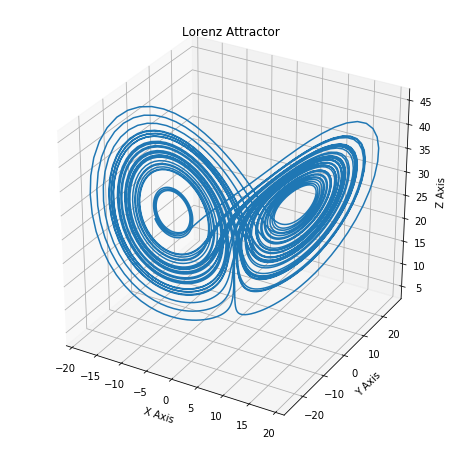

In [2]:
lorenz_test = Model()
lorenz_test.forward(5000)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[1,:,0], lorenz_test.xvar_series[2,:,0])
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")
plt.show()

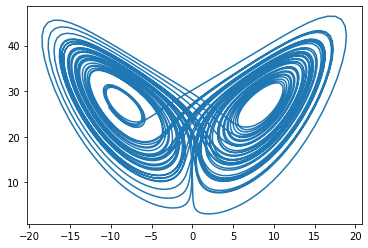

In [3]:
plt.figure()
plt.plot(lorenz_test.xvar_series[0,:,0], lorenz_test.xvar_series[2,:,0], '-')
plt.show()

## General set-up: length of integration
Number of time steps for all experiments:

In [4]:
ntime = 500

## Reference simulation
Run and plot a reference simulation. This simulation will serve as "truth" from which observations will extracted and assimilated. The graphs display the time evolution of $x$, $y$, $z$, respectively.

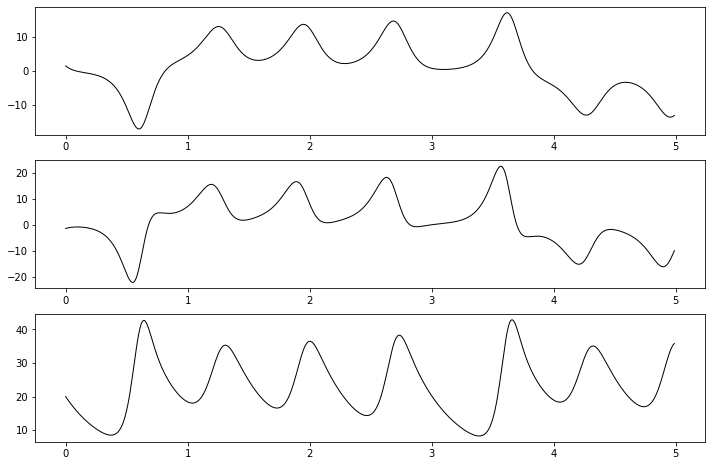

In [5]:
lorenz_ref = Model()
lorenz_ref.forward(ntime)
lorenz_ref.plot()
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

## Lorenz model with inaccurate initial condition
We define a "wrong" initial state:

In [6]:
wrong_state = np.array([3., -3., 21.])

And we examine the consequences of initializing the model with this wrong state rather than the "true" one. On the graph, the reference simulation is in black, the one with the wrong initial condition is in red.

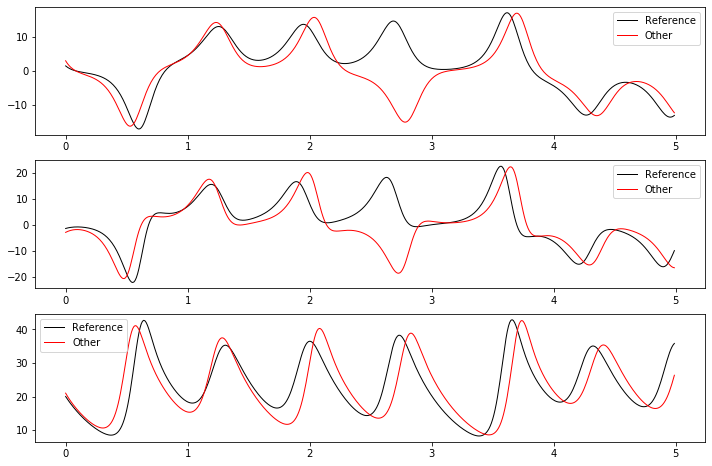

In [7]:
lorenz_test1 = Model()
lorenz_test1.x0 = np.copy(wrong_state)
lorenz_test1.xvar = lorenz_test1.initial_condition()
lorenz_test1.forward(ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.,label='Other')
    plt.legend()
plt.show()


## Lorenz model with inaccurate parameters
We now look at the consequences of a poor prescription of the $\rho$ parameter: 29 instead of 28.

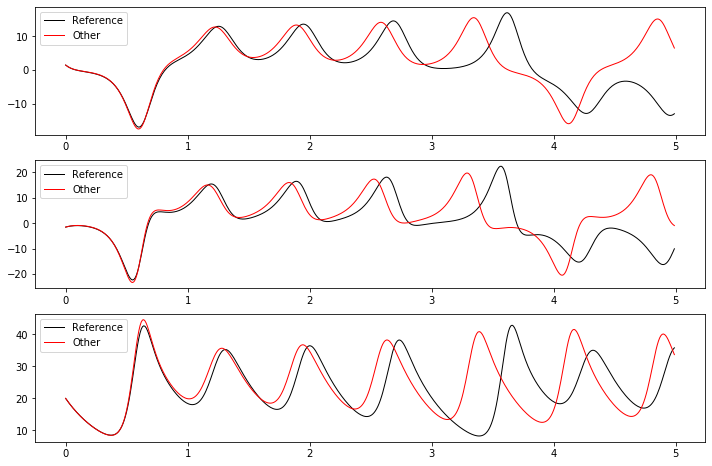

In [8]:
lorenz_test2 = Model()
lorenz_test2.rho = 29.
lorenz_test2.forward(ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test2.time_series,lorenz_test2.xvar_series[ix,:,0],'red',linewidth=1.,label='Other')
    plt.legend()
plt.show()

## Lorenz model with inaccurate initial conditions and inaccurate parameters
Finally, we put together a wrong initial state and an erroneous $\rho$ parameter. This reflects what actually happens when one uses a numerical model of a geophysical system: the numerical model is never perfect, and the initial condition is never perfectly known.

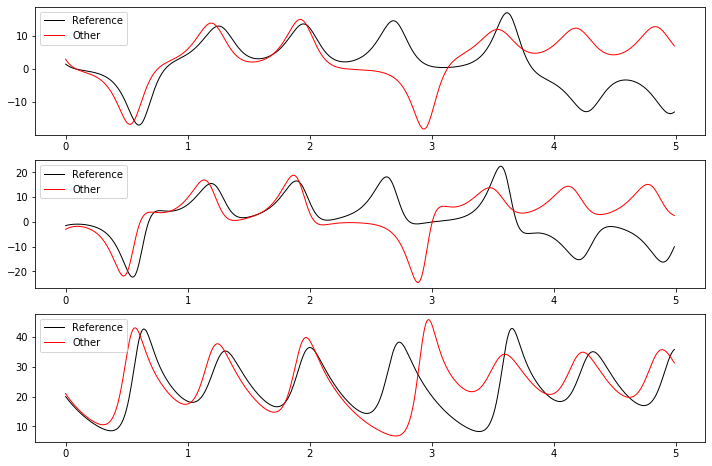

In [9]:
lorenz_test3 = Model()
lorenz_test3.x0 = np.copy(wrong_state)
lorenz_test3.xvar = lorenz_test3.initial_condition()
lorenz_test3.rho = 29.
lorenz_test3.forward(ntime)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(lorenz_test3.time_series,lorenz_test3.xvar_series[ix,:,0],'red',linewidth=1.,label='Other')
    plt.legend()
plt.show()

# Data assimilation
We now turn to data assimilation. We assume our model is inaccurate, and the initial condition is not perfectly known. To mimic this, we assimilate observations extracted from the reference simulation ($\rho=28$, initial condition = (1.5, -1.5, 21) ) into an unperfect model ($\rho=29$) initialized with unperfect conditions (3, -3, 21).

To make the experiment even closer to reality, we assume we have observations of the first variable $x$ only, and at a very limited number of time steps. This is stated in the cell below, with other operations necessary for the next steps.

In [10]:
#nvarobs = 0
#nvarobs = [0, 1]
nvarobs = [0, 2]
nobs = len(nvarobs)
assim_steps = range(25,150,25)
nassim = len(assim_steps)
lencycle = np.hstack((assim_steps[0], np.ediff1d(assim_steps)))

## First data assimilation experiment: direct substitution
Here, the model is run and each time an observation is available, it replaces the corresponding model value. This results in the "steps" clearly visible for $x$ on the red line.

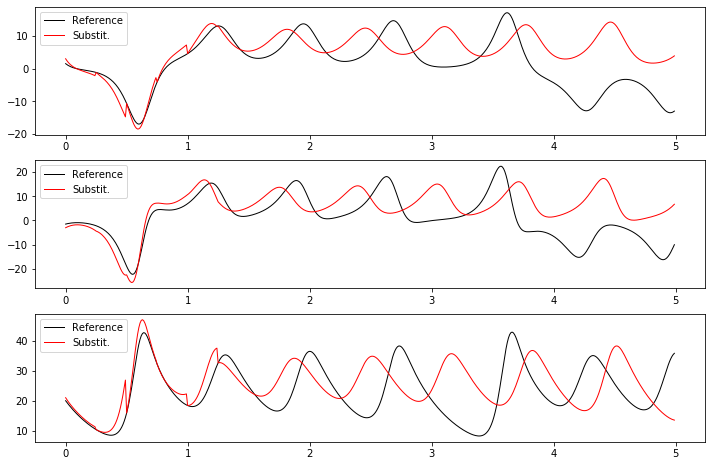

In [11]:
lorenz_assim1 = Model()
lorenz_assim1.x0 = np.copy(wrong_state)
lorenz_assim1.xvar = lorenz_assim1.initial_condition()
lorenz_assim1.rho = 29.

time1 = np.empty(ntime)
xvar1 = np.empty((3, ntime, 1))

for ic in range(nassim): 
    
    ## Forecast
    if ic == 0:
        nstep = assim_steps[0]
    else:
        nstep = assim_steps[ic] - assim_steps[ic-1]
        
    lorenz_assim1.forward(nstep)
    
    if ic == 0:
        time1 = lorenz_assim1.time_series
        xvar1 = lorenz_assim1.xvar_series
    else:
        time1 = np.hstack( ( time1, lorenz_assim1.time_series ) )
        xvar1 = np.concatenate( ( xvar1, lorenz_assim1.xvar_series ), axis = 1 )
    
    ## Analysis
    index = np.argwhere( true_time == lorenz_assim1.time )
    lorenz_assim1.xvar[nvarobs, 0] = true_state[nvarobs, index, 0]
       
## Last cycle
lorenz_assim1.forward( ntime - assim_steps[-1] )
time1 = np.hstack(( time1, lorenz_assim1.time_series ))
xvar1 = np.concatenate( ( xvar1, lorenz_assim1.xvar_series ), axis = 1 )
  
## Plots

plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(time1,xvar1[ix,:,0],'red',linewidth=1.,label='Substit.')
    plt.legend()
plt.show()

## Second data assimilation experiment: Ensemble Kalman filter
We perform the same experiment as above, same model, same observations, but with an Ensemble Kalman filter (EnKF). The EnKF is a Monte Carlo method, therefore requires the definition of an ensemble (sample) size. An estimation of the observation error variance is also needed.

In [19]:
nmem = 30
obserrstd = 1e-2
Robs = (obserrstd**2)*np.eye(nobs)

The big difference between the direct substitution experimented earlier and the EnKF tested below is: at each analysis step (i.e., each time an observation of $x$ is available and processed to correct the model), direct substitution corrects $x$ only. The EnKF corrects all variables, even if the observation is partial. This results in a much more accurate estimation of the model trajectory, in particular after the last available observation (at time 1.25 on the x axis). Long after the last observation though, the EnKF trajectory tends to diverge again, for 2 reasons: (i) the estimation at time 1.25 is not perfect and the model is chaotic, and (ii) the model is unperfect.

Note that the EnKF being a Monte Carlo method; it is the ensemble mean that is plotted in red below.

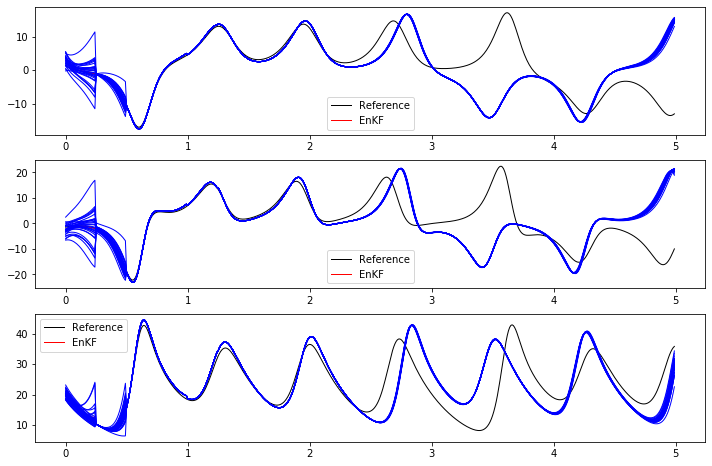

In [25]:
lorenz_assim2 = Model(nmembers=nmem)
lorenz_assim2.x0 = np.copy(wrong_state)
lorenz_assim2.xvar = lorenz_assim2.initial_condition()
lorenz_assim2.rho = 29.

time2 = np.empty(ntime)
xvar2 = np.empty((3, ntime, nmem))

for ic in range(nassim):
    
    ## Forecast
    if ic == 0:
        nstep = assim_steps[0]
    else:
        nstep = assim_steps[ic] - assim_steps[ic-1]
        
    lorenz_assim2.forward(nstep)
    
    if ic == 0:
        time2 = lorenz_assim2.time_series
        xvar2 = lorenz_assim2.xvar_series
    else:
        time2 = np.hstack(( time2, lorenz_assim2.time_series ))
        xvar2 = np.concatenate( ( xvar2, lorenz_assim2.xvar_series ), axis = 1 )
    
    ## Analysis
    obs_index = np.argwhere( true_time == lorenz_assim2.time )
    innovation = np.empty((nobs, nmem))
    innoverr = np.random.normal(0, obserrstd, (nobs, nmem) )
    for ie in range(nmem):
        innovation[:,ie] = true_state[nvarobs, obs_index, 0] - lorenz_assim2.xvar[nvarobs, ie] - innoverr[:,ie]
    xvar2mean = np.mean( lorenz_assim2.xvar, axis=1 )
    anomalies = np.empty_like(lorenz_assim2.xvar)
    for ie in range(lorenz_assim2.nmembers):
        anomalies[:,ie] = (lorenz_assim2.xvar[:,ie] - xvar2mean) / np.sqrt(lorenz_assim2.nmembers)
    hanom = anomalies[nvarobs, :]
    innovmat = Robs + np.inner(hanom,hanom)
    innovmat = np.linalg.inv(innovmat)
    Kgain = np.inner(anomalies, hanom)
    Kgain = np.inner(Kgain, innovmat)
    lorenz_assim2.xvar = lorenz_assim2.xvar + np.inner( Kgain, innovation.T )
       
## Last cycle
lorenz_assim2.forward( ntime - assim_steps[-1] )
time2 = np.hstack(( time2, lorenz_assim2.time_series ))
xvar2 = np.concatenate( ( xvar2, lorenz_assim2.xvar_series ), axis = 1 )

## Plots

xvar2mean = np.mean(xvar2, axis=2)

plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.,label='Reference')
    plt.plot(time2, xvar2mean[ix,:],'red',linewidth=1.,label='EnKF')
    plt.legend()
    for ie in range(nmem):
        plt.plot(time2, xvar2[ix,:, ie],'blue',linewidth=1.)
plt.show()

Below, the ensemble variances are plotted. The analyses reduce the variances.

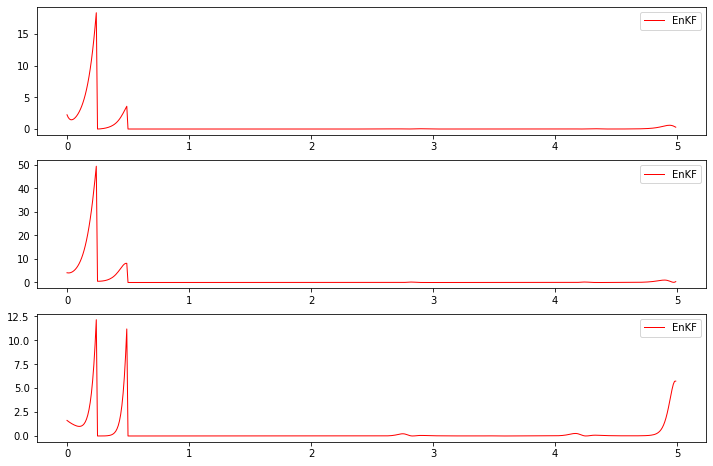

In [26]:
xvar2var = np.var(xvar2, axis=2)
plt.figure(figsize=(12,8))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(time2, xvar2var[ix,:],'red',linewidth=1.,label='EnKF')
    plt.legend()
plt.show()

In [24]:
np.random.normal(0, 1e-2, (nobs,nmem))

array([[ 0.00674427, -0.00436137, -0.00092638,  0.00883649, -0.00491336,
         0.00857926, -0.00373138, -0.00079879, -0.0094822 , -0.00469687,
         0.0287168 , -0.00241001, -0.00052773,  0.01020818, -0.00934986,
        -0.00506152,  0.01533156,  0.00938828, -0.01136987,  0.00599354,
        -0.0039101 ,  0.00269403,  0.01005936,  0.01223549,  0.01008905,
         0.00345179, -0.00864919, -0.021972  ,  0.00956829,  0.00361532],
       [-0.01093748,  0.01403311, -0.00259979,  0.00207512,  0.01281523,
        -0.00833326,  0.00210558,  0.01689655,  0.00509649, -0.00161413,
        -0.01336619,  0.00023401,  0.02236626,  0.00295809,  0.01541066,
         0.00829541,  0.00522542, -0.00668165,  0.00331726,  0.0065861 ,
         0.00101059,  0.01284555, -0.01132223,  0.00050763, -0.00960309,
        -0.00042866,  0.01050288,  0.01210251, -0.00240337, -0.00064601]])

In [21]:
nobs

2

In [22]:
nmem

30